In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import copy
sys.path.append('/users/mtaranov/genome3D/')
from models_3d import Genome3D_DNN_FC
from utils import get_features, get_labels, subsample_data, normalize_features, makedirs

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
contacts='pe'
thres='10'
path='/users/mtaranov/datasets_3d/by_chr_dist_matched_'+contacts+'/'
X_train = get_features(path+'d0_X_train_thres_10.npy')
y_train = get_labels(path+'d0_y_train_thres_10.npy')
X_valid = get_features(path+'d0_X_valid_thres_10.npy')
y_valid = get_labels(path+'d0_y_valid_thres_10.npy')
X_test = get_features(path+'d0_X_test_thres_10.npy')
y_test = get_labels(path+'d0_y_test_thres_10.npy')

In [3]:
X_train_normalized, X_valid_normalized, X_test_normalized = normalize_features(X_train, X_valid, X_test)

In [4]:
X_train_pairs = X_train_normalized.reshape(X_train_normalized.shape[0],X_train_normalized.shape[2]*X_train_normalized.shape[3])
X_valid_pairs = X_valid_normalized.reshape(X_valid_normalized.shape[0],X_valid_normalized.shape[2]*X_valid_normalized.shape[3])
X_test_pairs = X_test_normalized.reshape(X_test_normalized.shape[0],X_test_normalized.shape[2]*X_test_normalized.shape[3])

# without genomic location

In [5]:
dnn_normalized = Genome3D_DNN_FC(num_features=18, use_deep_CNN=True)
validation_data = (X_valid_pairs[:,:18], y_valid)
dnn_normalized.train(X_train_pairs[:,:18], y_train, validation_data)

Training model...
Train on 6710 samples, validate on 1796 samples
Epoch 1/100
6500/6710 [============================>.] - ETA: 0s - loss: 1.5414Epoch 0: validation loss: 0.706
Balanced Accuracy: 57.07%	auROC: 0.602	 auPRC: 0.607
Positve Accuracy: 0.33%	 Negative Accuracy: 36.97%
Recall at 5% | 10% | 25% | 50% FDR: 77.2% | 0.3% | 9.0% | 89.1%	Num Positives: 898	 Num Negatives: 898


6710/6710 [==============================] - 5s - loss: 1.5393 - val_loss: 0.7063
Epoch 2/100
6500/6710 [============================>.] - ETA: 0s - loss: 1.4303Epoch 1: validation loss: 0.658
Balanced Accuracy: 60.63%	auROC: 0.682	 auPRC: 0.661
Positve Accuracy: 0.78%	 Negative Accuracy: 44.21%
Recall at 5% | 10% | 25% | 50% FDR: 77.1% | 0.8% | 13.1% | 99.3%	Num Positives: 898	 Num Negatives: 898


6710/6710 [==============================] - 5s - loss: 1.4278 - val_loss: 0.6577
Epoch 3/100
6500/6710 [============================>.] - ETA: 0s - loss: 1.3289Epoch 2: validation loss: 0.630
Balanced Accuracy:

In [6]:
print(dnn_normalized.test(X_test_pairs[:,:18], y_test))
print(dnn_normalized.test(X_train_pairs[:,:18], y_train))
print(dnn_normalized.test(X_valid_pairs[:,:18], y_valid))

Balanced Accuracy: 69.43%	auROC: 0.761	 auPRC: 0.747
Positve Accuracy: 1.42%	 Negative Accuracy: 68.83%
Recall at 5% | 10% | 25% | 50% FDR: 70.0% | 1.4% | 61.5% | 100.0%	Num Positives: 494	 Num Negatives: 494

Balanced Accuracy: 77.48%	auROC: 0.848	 auPRC: 0.854
Positve Accuracy: 27.36%	 Negative Accuracy: 77.56%
Recall at 5% | 10% | 25% | 50% FDR: 77.4% | 44.7% | 80.5% | 100.0%	Num Positives: 3355	 Num Negatives: 3355

Balanced Accuracy: 74.94%	auROC: 0.811	 auPRC: 0.807
Positve Accuracy: 1.11%	 Negative Accuracy: 72.83%
Recall at 5% | 10% | 25% | 50% FDR: 77.1% | 23.6% | 74.1% | 100.0%	Num Positives: 898	 Num Negatives: 898



# DeepLift

In [7]:
#save model and weights
dnn_normalized.save(contacts+'_dnn_FC_linear_genomic_features_'+'thres_'+thres, '/users/mtaranov/genome3D/')

In [8]:
weights='/users/mtaranov/genome3D/model_weights/'+contacts+'_dnn_FC_linear_genomic_features_'+'thres_'+thres+'.weights.h5'
json_model='/users/mtaranov/genome3D/models/'+contacts+'_dnn_FC_linear_genomic_features_'+'thres_'+thres+'.arch.json'

In [9]:
scores = dnn_normalized.deeplift(X_valid_pairs[:,:18][np.where(y_valid ==1)[0]], weights, json_model, batch_size=128)

True
nonlinear_mxts_mode is set to: RevealCancel


In [10]:
np.save('/users/mtaranov/genome3D/model_deeplift_scores/'+contacts+'_scores_dnn_FC_linear_genomic_features.npy', scores)

In [11]:
scores.shape

(898, 18)

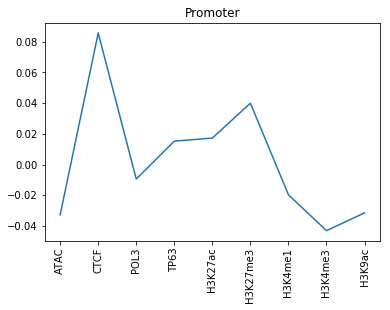

In [12]:
features = ['ATAC', 'CTCF', 'POL3', 'TP63', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K9ac']
plt.plot(np.mean(scores, axis=0)[0:18:2])
x = [float(j) for j in range(np.shape(scores)[1]/2)]
plt.xticks(x, features, rotation='vertical')
plt.title('Promoter')

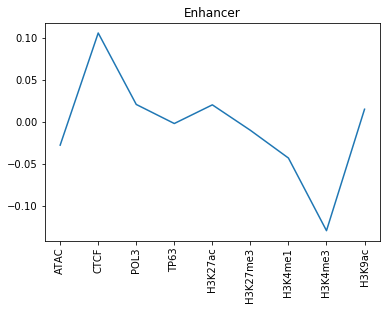

In [13]:
features = ['ATAC', 'CTCF', 'POL3', 'TP63', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K9ac']
plt.plot(np.mean(scores, axis=0)[1:19:2])
x = [float(j) for j in range(np.shape(scores)[1]/2)]
plt.xticks(x, features, rotation='vertical')
plt.title('Enhancer')

# with genomic locations

In [14]:
dnn_normalized = Genome3D_DNN_FC(num_features=20, use_deep_CNN=True)
validation_data = (X_valid_pairs, y_valid)
dnn_normalized.train(X_train_pairs, y_train, validation_data)

Training model...
Train on 6710 samples, validate on 1796 samples
Epoch 1/100
6500/6710 [============================>.] - ETA: 0s - loss: 1.4368Epoch 0: validation loss: 0.694
Balanced Accuracy: 57.07%	auROC: 0.586	 auPRC: 0.582
Positve Accuracy: 0.00%	 Negative Accuracy: 50.67%
Recall at 5% | 10% | 25% | 50% FDR: 63.5% | 0.0% | 3.6% | 100.0%	Num Positives: 898	 Num Negatives: 898


6710/6710 [==============================] - 4s - loss: 1.4346 - val_loss: 0.6942
Epoch 2/100
6250/6710 [==========================>...] - ETA: 0s - loss: 1.3309Epoch 1: validation loss: 0.639
Balanced Accuracy: 63.03%	auROC: 0.685	 auPRC: 0.662
Positve Accuracy: 0.00%	 Negative Accuracy: 59.24%
Recall at 5% | 10% | 25% | 50% FDR: 66.8% | 0.0% | 16.7% | 100.0%	Num Positives: 898	 Num Negatives: 898


6710/6710 [==============================] - 4s - loss: 1.3290 - val_loss: 0.6385
Epoch 3/100
6250/6710 [==========================>...] - ETA: 0s - loss: 1.2656Epoch 2: validation loss: 0.607
Balanced Accurac

In [15]:
print(dnn_normalized.test(X_test_pairs, y_test))
print(dnn_normalized.test(X_train_pairs, y_train))
print(dnn_normalized.test(X_valid_pairs, y_valid))

Balanced Accuracy: 73.79%	auROC: 0.794	 auPRC: 0.799
Positve Accuracy: 9.31%	 Negative Accuracy: 70.04%
Recall at 5% | 10% | 25% | 50% FDR: 77.5% | 18.6% | 71.3% | 100.0%	Num Positives: 494	 Num Negatives: 494

Balanced Accuracy: 79.24%	auROC: 0.874	 auPRC: 0.876
Positve Accuracy: 31.48%	 Negative Accuracy: 78.63%
Recall at 5% | 10% | 25% | 50% FDR: 79.9% | 54.3% | 85.1% | 100.0%	Num Positives: 3355	 Num Negatives: 3355

Balanced Accuracy: 77.17%	auROC: 0.861	 auPRC: 0.853
Positve Accuracy: 20.94%	 Negative Accuracy: 70.60%
Recall at 5% | 10% | 25% | 50% FDR: 83.7% | 37.5% | 83.4% | 100.0%	Num Positives: 898	 Num Negatives: 898

